In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Mounted at /content/drive


In [2]:
# modelo
m = 2
# tamanho da janela deslizante
n = 3
# ataque
at = 2
veremiPath = "/content/drive/MyDrive/dataset/veremi"
t2Path = "/veremiWithT2"
simcsvPath = '/simulationscsv'
window = "/window"+str(n)+"v2"
model = "/model"+str(m)
preprocessing = "/preprocessing"
atk = "/atk"+str(at)
svmPath = '/svm'

os.chdir(veremiPath+t2Path+window+model+'/allscenarios2')
multi = pd.read_csv('allsc2.csv', index_col=0)

# os.chdir(veremiPath+t2Path+window+svmPath+model+atk)
# os.listdir()

In [3]:
# transformar os demais ataques em label 0
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MultiLabelBinarizer
df = multi
df = df.drop(df.loc[df.iloc[:, -1] == 0].sample(frac=0.75, random_state=7).index)
df.iloc[:, -1].loc[df.iloc[:, -1] != at] = 0
# df.iloc[:, -1].unique()
# split data and label
data = df.iloc[:, 0:-1].values
classes = df.iloc[:, -1].values
# multilabel binarize
lb = preprocessing.LabelBinarizer()
lb.fit(classes)
# split test and train
data_train, data_test, classes_train, classes_test = train_test_split(data, classes, train_size=0.01, test_size=0.01, random_state=1)
print('data_train', data_train.shape)
print('data_test', data_test.shape)
print('classes_train', classes_train.shape)
print('classes_test', classes_test.shape)

data_train (73578, 2)
data_test (73579, 2)
classes_train (73578,)
classes_test (73579,)


In [4]:
from sklearn import svm
start_time = time.time()
clf = svm.SVC(probability=True)
clf.fit(data_train, classes_train)
print('Training done in ', "{:.2f}".format(time.time() - start_time)+' sec', sep='')
proba = clf.predict_proba(data_test)

Training done in 371.45 sec


Best Threshold=0.010204, F-Score=0.197
----------------------------------------------------------------------
Classification Report for md2svmat2
              precision    recall  f1-score   support

   class all      1.000     0.108     0.195     66308
     class 2      0.109     1.000     0.197      7271

    accuracy                          0.196     73579
   macro avg      0.555     0.554     0.196     73579
weighted avg      0.912     0.196     0.195     73579

----------------------------------------------------------------------


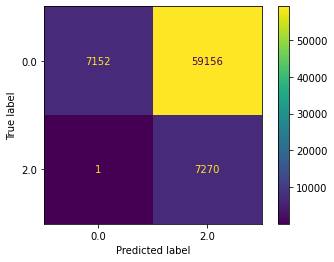

----------------------------------------------------------------------


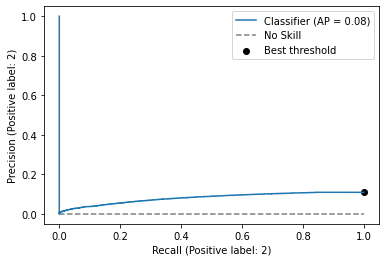

----------------------------------------------------------------------


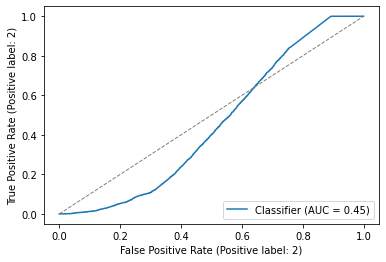

In [5]:
# metrics
clTest = classes_test
os.chdir(veremiPath+t2Path+window+svmPath+model+atk)
# Best threshold
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(clTest, proba[:, 1], pos_label=at)
# convert to f score
np.seterr(divide='ignore', invalid='ignore')
fscore = (2 * precision * recall) / (precision + recall)
np.nan_to_num(fscore, copy=False)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
print("-"*70)
# Classification Report
from sklearn.metrics import classification_report
pred = np.where(np.array(proba[:, 1]) >= thresholds[ix], at, 0)
print('Classification Report for md'+str(m)+'svm'+'at'+str(at))
print(classification_report(clTest, pred, target_names=['class all', 'class '+str(at)], digits=3, zero_division=0))
print("-"*70)
# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# predrelu = lb.inverse_transform(predictsrelu, threshold=thresholds[ix])
cm = confusion_matrix(clTest, pred, labels=lb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lb.classes_)
disp.plot()
# plt.title('md'+str(m)+'w'+str(n)+'binary'+'.pdf')
plt.savefig('md'+str(m)+'svm'+'at'+str(at)+'.pdf')
plt.show()
print("-"*70)
# Precision-Recall curve
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(clTest, proba[:, 1], pos_label=at)
# plt.title('PR curve '+'md'+str(m)+'w'+str(n)+'binary'+'.pdf')
no_skill = len(clTest[clTest==1]) / len(clTest)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', color="grey", label='No Skill')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best threshold')
plt.legend()
plt.savefig('PRcurve '+'md'+str(m)+'svm'+'at'+str(at)+'.pdf')
plt.show()
print("-"*70)
# ROC curve
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(clTest, proba[:, 1], pos_label=at)
# plt.title('ROC curve '+'md'+str(m)+'w'+str(n)+'binary'+'.pdf')
plt.plot([0, 1], [0, 1], color="grey", lw=1, linestyle="--")
plt.savefig('ROCcurve '+'md'+str(m)+'svm'+'at'+str(at)+'.pdf')
plt.show()